# Preparation

## Library

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import AdamW, get_linear_schedule_with_warmup


from fetchData import fetchdata, cv_events
import __MLP
import __Preprocessing
# from __MLP import getSamplers, convert_df_to_unsqueezed_tensor, train_sequential, clf_report
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', 150)

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Data

In [8]:
# pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
# pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
# pheme_bert = fetchdata('pheme','bert')
# pheme_thread =  fetchdata('pheme','thread')
# pheme_thread_log = pd.read_csv('./data/_PHEME_thread_log.csv')
# pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')

# ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
# ext_bert = fetchdata('ext','bert')
# ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
# ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')

# ext_thread = fetchdata('ext','thread')
# ext_thread_log = pd.read_csv('./data/_PHEMEext_thread_log.csv')
# ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

# rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
# rhi_y = pd.read_csv('./data/_RHI_target.csv')
# rhi_bert = fetchdata('rhi','bert')



# pheme_bert_twttknr = pd.read_csv('./data/_PHEME_Bert_twttknzr.csv')
# ext_bert_twttknr = pd.read_csv('./data/_PHEMEext_Bert_twttknzr.csv')
# pheme_bert_lemma = pd.read_csv('./data/_PHEME_Bert_lemma.csv')
# pheme_bert_twttknr_lemma = pd.read_csv('./data/_PHEME_Bert_simple_twtknzr_lemma.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
# ext_bert_lemma = pd.read_csv('./data/_PHEMEext_Bert_lemma.csv')
# ext_bert_twttknr_lemma = pd.read_csv('./data/_PHEMEext_Bert_simple_twtknzr_lemma.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
set_seed()

In [9]:
pheme_bert_simple = pd.read_csv('./data/_PHEME_Bert_final.csv')
pheme_bert_bracket = pd.read_csv('./data/_PHEME_Bert_final_brackets.csv')
pheme_bert_simple_normal = pd.read_csv('./data/_PHEME_Bert_final_nrmzd.csv')
pheme_bert_brackets_normal = pd.read_csv('./data/_PHEME_Bert_final_brackets_nrmzd.csv')
ext_bert_simple = pd.read_csv('./data/_PHEMEext_Bert_final.csv')
ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_final_brackets.csv')
ext_bert_simple_normal = pd.read_csv('./data/_PHEMEext_Bert_final_brackets.csv')
ext_bert_brackets_normal = pd.read_csv('./data/_PHEMEext_Bert_final_brackets_nrmzd.csv')

pheme_bert_twttknr = pd.read_csv('./data/_PHEME_Bert_twttknzr.csv')
ext_bert_twttknr = pd.read_csv('./data/_PHEMEext_Bert_twttknzr.csv')

In [6]:
pd.concat([pheme_event,ext_event]).value_counts()

charliehebdo         2079
sydneysiege          1221
ferguson             1143
ottawashooting        890
germanwings-crash     469
putinmissing          238
prince-toronto        233
ebola-essien           14
Name: Event, dtype: int64

In [7]:
# cv = Preprocessing.cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))
# X = cv[3][1].drop(['target', 'Event'],axis=1)
# y = cv[3][1].target
# val_X = cv[3][0].drop(['target', 'Event'],axis=1)
# val_y = cv[3][0].target

## Class

In [329]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [330]:
import os
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)


# BERT Simple

In [331]:
cv = __Preprocessing.cv_events(pd.concat([pheme_bert_simple, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [332]:
# CV ver.

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(X.values, y, val_X.values, val_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0403), std: tensor(0.3296)
torch.Size([4912, 1, 768]) torch.Size([890, 1, 768])
torch.Size([4912, 1]) torch.Size([890, 1])
Train Size 4912 Test Size 890


In [172]:
# Non-CV ver.

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_simple.values, pheme_y, ext_bert_simple.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0401), std: tensor(0.3297)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [333]:
epochs = 100

model_bert = BERT_net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_simple.pt"

In [334]:
# seed = 0
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)

train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6128, Loss: 0.6751
		Validation) Acc: 0.6888 Loss:0.6421
			Saving the best model w/ val loss 0.6421
			Saving the best model w/ val loss 0.5459
Epoch 2/99	Train) Acc: 0.7877, Loss: 0.5146
		Validation) Acc: 0.7775 Loss:0.4925
			Saving the best model w/ val loss 0.4925
			Saving the best model w/ val loss 0.4784
Epoch 4/99	Train) Acc: 0.7818, Loss: 0.4845
		Validation) Acc: 0.7719 Loss:0.4903
Epoch 6/99	Train) Acc: 0.8090, Loss: 0.4457
		Validation) Acc: 0.7719 Loss:0.4750
			Saving the best model w/ val loss 0.4750
Epoch 8/99	Train) Acc: 0.8060, Loss: 0.4497
		Validation) Acc: 0.7449 Loss:0.5207
Epoch 10/99	Train) Acc: 0.8182, Loss: 0.4318
		Validation) Acc: 0.7652 Loss:0.4834
Epoch 12/99	Train) Acc: 0.8204, Loss: 0.4273
		Validation) Acc: 0.7629 Loss:0.4830
Epoch 14/99	Train) Acc: 0.8180, Loss: 0.4279
		Validation) Acc: 0.7629 Loss:0.4975
Epoch 16/99	Train) Acc: 0.8253, Loss: 0.4158
		Validation) Acc: 0.7607 Loss:0.4987
Epoch 18/99	Train) Acc: 0.8213, Loss: 

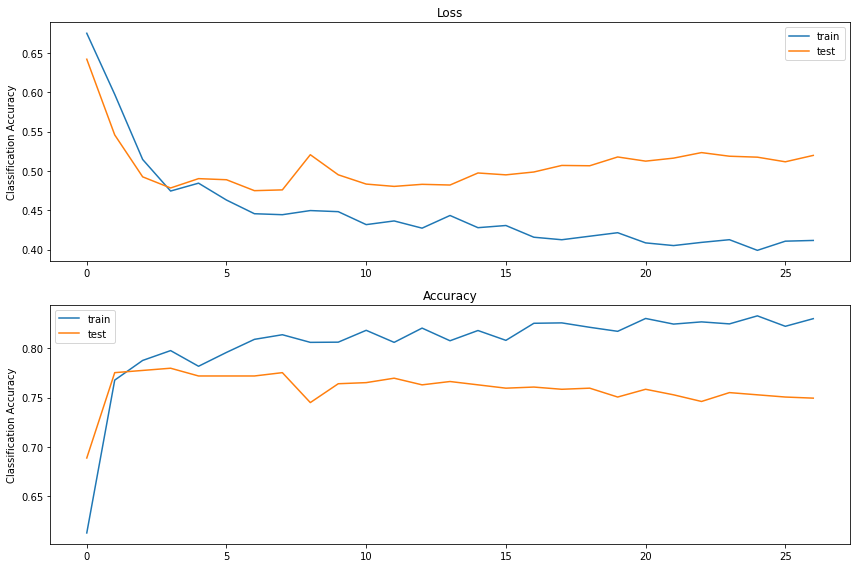

Min of Training Loss: 0.399109
Max of Training Accuracy: 0.832858
Mean of Training Loss: 0.448854
Mean of Training Accuracy: 0.805088
------------
Max of Testing Accuracy: 0.779775
Min of Testing Loss: 0.474977
Mean of Testing Loss: 0.506537
Mean of Testing Accuracy: 0.759342
------------


In [335]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [336]:
test_dataloader, test_size = test_data_process(ext_bert_simple, ext_y)
# testloader_brackets, test_size = test_data_process(rhi_brakcet, rhi_y.isRumor)

mean: tensor(0.0410), std: tensor(0.3278)
Test Size 485


In [337]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_simple.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.4577
Precision Score:	0.8955
Recall Score:		0.3252
f1_score:		0.3871
Test_loss:		0.8139


# BERT Brackets

In [296]:
cv = __Preprocessing.cv_events(pd.concat([pheme_bert_bracket, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [297]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(X.values, y, val_X.values, val_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0398), std: tensor(0.3301)
torch.Size([4912, 1, 768]) torch.Size([890, 1, 768])
torch.Size([4912, 1]) torch.Size([890, 1])
Train Size 4912 Test Size 890


In [338]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_bracket.values, pheme_y, ext_bert_bracket.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0401), std: tensor(0.3299)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [339]:
epochs=100

model_bert = BERT_net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_brackets.pt"

In [340]:

train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6873, Loss: 0.6577
		Validation) Acc: 0.4062 Loss:0.7114
			Saving the best model w/ val loss 0.7114
Epoch 2/99	Train) Acc: 0.7873, Loss: 0.4837
		Validation) Acc: 0.3753 Loss:0.8891
Epoch 4/99	Train) Acc: 0.8008, Loss: 0.4517
		Validation) Acc: 0.4454 Loss:0.8522
Epoch 6/99	Train) Acc: 0.8042, Loss: 0.4436
		Validation) Acc: 0.4866 Loss:0.8087
Epoch 8/99	Train) Acc: 0.8140, Loss: 0.4331
		Validation) Acc: 0.4722 Loss:0.8527
Epoch 10/99	Train) Acc: 0.8170, Loss: 0.4229
		Validation) Acc: 0.4969 Loss:0.8298
Epoch 12/99	Train) Acc: 0.8170, Loss: 0.4217
		Validation) Acc: 0.4206 Loss:0.9433
Epoch 14/99	Train) Acc: 0.8140, Loss: 0.4283
		Validation) Acc: 0.5423 Loss:0.7696
Epoch 16/99	Train) Acc: 0.8187, Loss: 0.4181
		Validation) Acc: 0.5629 Loss:0.7606
Epoch 18/99	Train) Acc: 0.8325, Loss: 0.3952
		Validation) Acc: 0.6186 Loss:0.7125
Epoch 20/99	Train) Acc: 0.8194, Loss: 0.4182
		Validation) Acc: 0.5732 Loss:0.7641
Finishing the Model: Val Loss is not decreasing.

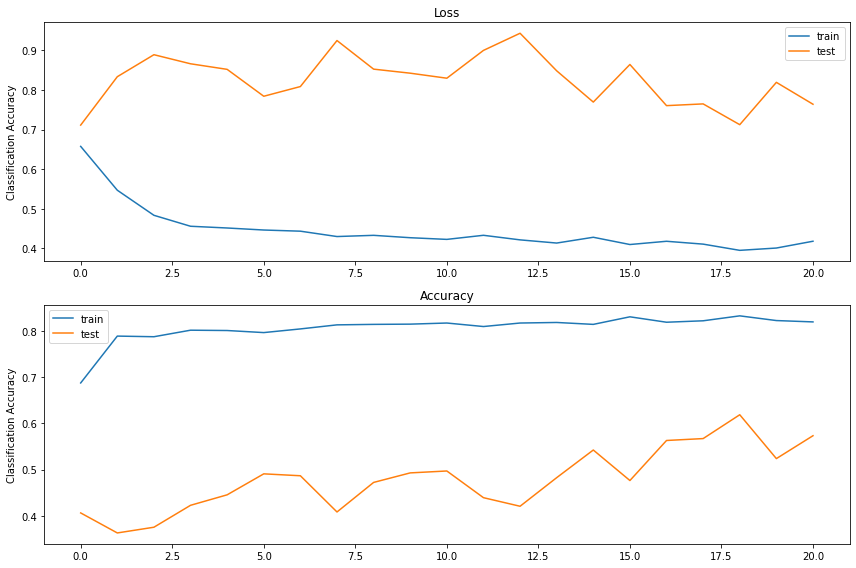

Min of Training Loss: 0.395240
Max of Training Accuracy: 0.832472
Mean of Training Loss: 0.445237
Mean of Training Accuracy: 0.806101
------------
Max of Testing Accuracy: 0.618557
Min of Testing Loss: 0.711442
Mean of Testing Loss: 0.825843
Mean of Testing Accuracy: 0.479332
------------


In [341]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [342]:
test_dataloader, test_size = test_data_process(ext_bert_bracket, ext_y)
# testloader_brackets, test_size = test_data_process(rhi_brakcet, rhi_y.isRumor)

mean: tensor(0.0410), std: tensor(0.3278)
Test Size 485


In [343]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_brackets.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.4062
Precision Score:	0.9091
Recall Score:		0.2439
f1_score:		0.3748
Test_loss:		0.7114


# BERT Simple + Normalization

In [356]:
cv = __Preprocessing.cv_events(pd.concat([pheme_bert_simple_normal, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [357]:
# CV ver.

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(X.values, y, val_X.values, val_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0395), std: tensor(0.3311)
torch.Size([4912, 1, 768]) torch.Size([890, 1, 768])
torch.Size([4912, 1]) torch.Size([890, 1])
Train Size 4912 Test Size 890


In [344]:
# non-CV ver.

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_simple_normal.values, pheme_y, ext_bert_simple_normal.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0396), std: tensor(0.3304)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [358]:
epochs=100

model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_simple_nrm.pt"

In [359]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6307, Loss: 0.6677
		Validation) Acc: 0.7517 Loss:0.6301
			Saving the best model w/ val loss 0.6301
			Saving the best model w/ val loss 0.5263
Epoch 2/99	Train) Acc: 0.7952, Loss: 0.4946
		Validation) Acc: 0.7798 Loss:0.4855
			Saving the best model w/ val loss 0.4855
			Saving the best model w/ val loss 0.4750
Epoch 4/99	Train) Acc: 0.7877, Loss: 0.4709
		Validation) Acc: 0.7697 Loss:0.4900
Epoch 6/99	Train) Acc: 0.8180, Loss: 0.4337
		Validation) Acc: 0.7730 Loss:0.4705
			Saving the best model w/ val loss 0.4705
			Saving the best model w/ val loss 0.4697
Epoch 8/99	Train) Acc: 0.8082, Loss: 0.4365
		Validation) Acc: 0.7663 Loss:0.5089
Epoch 10/99	Train) Acc: 0.8198, Loss: 0.4220
		Validation) Acc: 0.7820 Loss:0.4742
Epoch 12/99	Train) Acc: 0.8243, Loss: 0.4160
		Validation) Acc: 0.7809 Loss:0.4761
Epoch 14/99	Train) Acc: 0.8188, Loss: 0.4164
		Validation) Acc: 0.7764 Loss:0.4847
Epoch 16/99	Train) Acc: 0.8233, Loss: 0.4084
		Validation) Acc: 0.7742 Loss:0

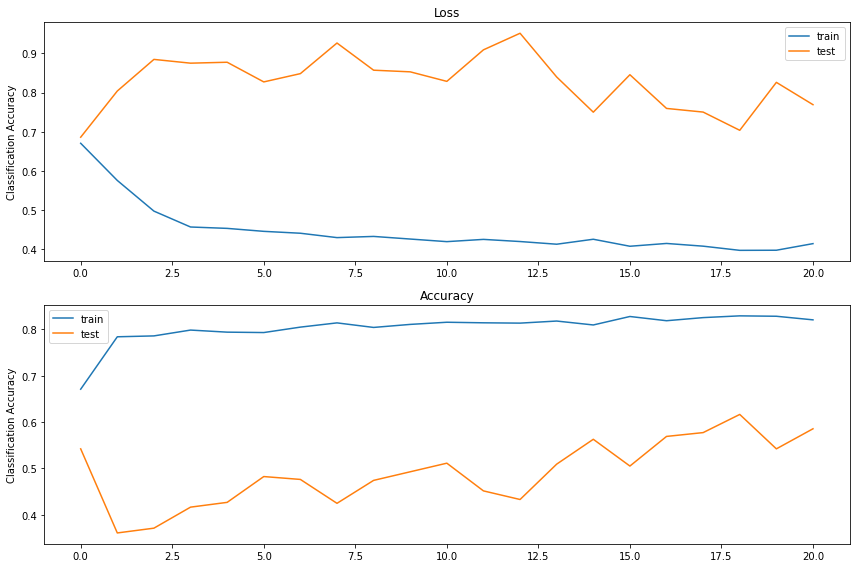

Min of Training Loss: 0.396933
Max of Training Accuracy: 0.829197
Mean of Training Loss: 0.446004
Mean of Training Accuracy: 0.803869
------------
Max of Testing Accuracy: 0.616495
Min of Testing Loss: 0.686028
Mean of Testing Loss: 0.827385
Mean of Testing Accuracy: 0.491998
------------


In [347]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [360]:
test_dataloader, test_size = test_data_process(ext_bert_simple_normal, ext_y)
# testloader_brackets, test_size = test_data_process(rhi_brakcet, rhi_y.isRumor)

mean: tensor(0.0410), std: tensor(0.3278)
Test Size 485


In [361]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_simple_nrm.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.4454
Precision Score:	0.8788
Recall Score:		0.3144
f1_score:		0.3773
Test_loss:		0.8624


# BERT Brakets + Normalization

In [362]:
cv = __Preprocessing.cv_events(pd.concat([pheme_bert_brackets_normal, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [363]:
# CV ver.

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(X.values, y, val_X.values, val_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0395), std: tensor(0.3304)
torch.Size([4912, 1, 768]) torch.Size([890, 1, 768])
torch.Size([4912, 1]) torch.Size([890, 1])
Train Size 4912 Test Size 890


In [350]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_brackets_normal.values, pheme_y, ext_bert_brackets_normal.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0396), std: tensor(0.3304)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [364]:
epochs=100
model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_brackets_nrm.pt"

In [365]:
set_seed()
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6270, Loss: 0.6722
		Validation) Acc: 0.7270 Loss:0.6360
			Saving the best model w/ val loss 0.6360
			Saving the best model w/ val loss 0.5310
Epoch 2/99	Train) Acc: 0.7917, Loss: 0.5023
		Validation) Acc: 0.7865 Loss:0.4817
			Saving the best model w/ val loss 0.4817
			Saving the best model w/ val loss 0.4696
Epoch 4/99	Train) Acc: 0.7871, Loss: 0.4734
		Validation) Acc: 0.7764 Loss:0.4833
Epoch 6/99	Train) Acc: 0.8196, Loss: 0.4352
		Validation) Acc: 0.7730 Loss:0.4660
			Saving the best model w/ val loss 0.4660
			Saving the best model w/ val loss 0.4656
Epoch 8/99	Train) Acc: 0.8052, Loss: 0.4389
		Validation) Acc: 0.7663 Loss:0.5025
Epoch 10/99	Train) Acc: 0.8192, Loss: 0.4243
		Validation) Acc: 0.7798 Loss:0.4704
Epoch 12/99	Train) Acc: 0.8235, Loss: 0.4182
		Validation) Acc: 0.7775 Loss:0.4718
Epoch 14/99	Train) Acc: 0.8170, Loss: 0.4181
		Validation) Acc: 0.7775 Loss:0.4801
Epoch 16/99	Train) Acc: 0.8223, Loss: 0.4106
		Validation) Acc: 0.7742 Loss:0

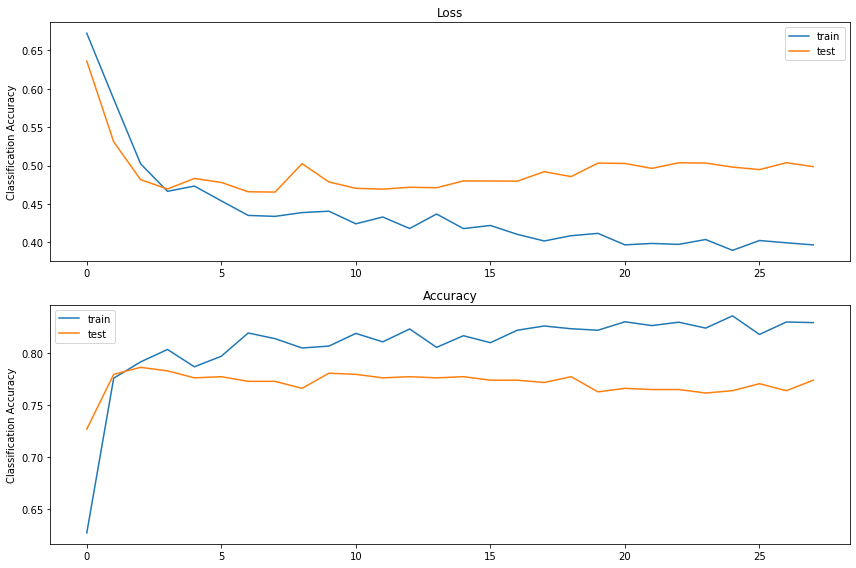

Min of Training Loss: 0.389771
Max of Training Accuracy: 0.836116
Mean of Training Loss: 0.438418
Mean of Training Accuracy: 0.808421
------------
Max of Testing Accuracy: 0.786517
Min of Testing Loss: 0.465582
Mean of Testing Loss: 0.492765
Mean of Testing Accuracy: 0.771549
------------


In [366]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [367]:
test_dataloader, test_size = test_data_process(ext_bert_brackets_normal, ext_y)
# testloader_brackets, test_size = test_data_process(rhi_brakcet, rhi_y.isRumor)

mean: tensor(0.0406), std: tensor(0.3289)
Test Size 485


In [368]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_brackets_nrm.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.3959
Precision Score:	0.8519
Recall Score:		0.2493
f1_score:		0.3112
Test_loss:		0.9128


# BERT Simple + TKNZER

In [ ]:
cv = __Preprocessing.cv_events(pd.concat([pheme_bert_twttknr, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [ ]:
# CV ver.

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(X.values, y, val_X.values, val_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

In [23]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_twttknr.values, pheme_y, ext_bert_twttknr.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0398), std: tensor(0.3307)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [24]:
epochs = 100
model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_twttknzr.pt"

In [25]:
set_seed()
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6374, Loss: 0.6759
		Validation) Acc: 0.5835 Loss:0.6851
			Saving the best model w/ val loss 0.6851
Epoch 2/99	Train) Acc: 0.7611, Loss: 0.5530
		Validation) Acc: 0.3526 Loss:0.8267
Epoch 4/99	Train) Acc: 0.7821, Loss: 0.4876
		Validation) Acc: 0.3897 Loss:0.8938
Epoch 6/99	Train) Acc: 0.7885, Loss: 0.4753
		Validation) Acc: 0.4247 Loss:0.8852
Epoch 8/99	Train) Acc: 0.7877, Loss: 0.4672
		Validation) Acc: 0.4680 Loss:0.8587
Epoch 10/99	Train) Acc: 0.7944, Loss: 0.4501
		Validation) Acc: 0.4887 Loss:0.8679
Epoch 12/99	Train) Acc: 0.7970, Loss: 0.4446
		Validation) Acc: 0.4474 Loss:0.9207
Epoch 14/99	Train) Acc: 0.7935, Loss: 0.4542
		Validation) Acc: 0.5052 Loss:0.8551
Finishing the Model: Val Loss is not decreasing...
[0.8679489644532351, 0.9180061744660446, 0.9206991634418055, 0.8844947651489494, 0.855149313469523]


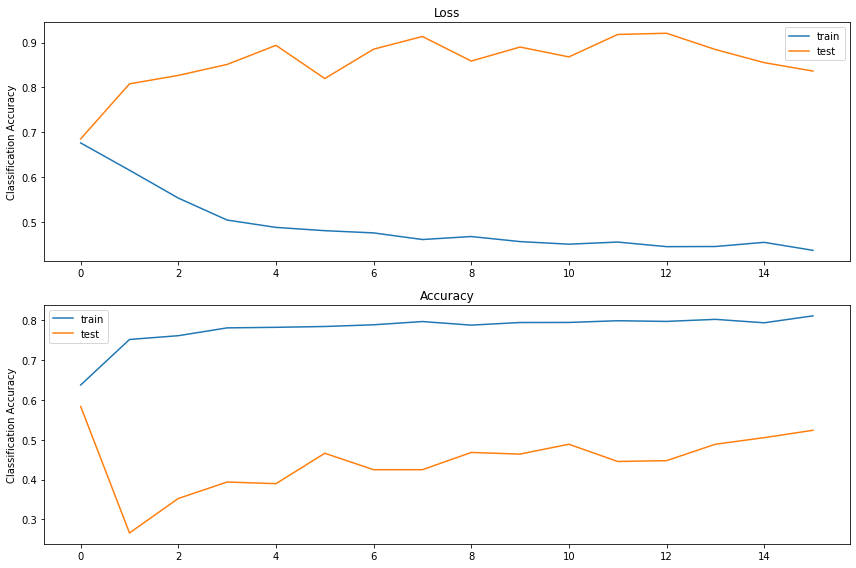

Min of Training Loss: 0.436365
Max of Training Accuracy: 0.810927
Mean of Training Loss: 0.491228
Mean of Training Accuracy: 0.778805
------------
Max of Testing Accuracy: 0.583505
Min of Testing Loss: 0.685082
Mean of Testing Loss: 0.857130
Mean of Testing Accuracy: 0.445747
------------


In [26]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [27]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_twttknzr.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.5835
Precision Score:	0.8646
Recall Score:		0.5366
f1_score:		0.5364
Test_loss:		0.6851


# BERT Lemma

In [217]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_lemma.values, pheme_y, ext_bert_lemma.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

NameError: name 'pheme_bert_lemma' is not defined

In [48]:
epochs = 100

model_bert = BERT_net()
total_steps = len(train_dataloader) * epochs

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_lemma.pt"

In [49]:
set_seed()
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6048, Loss: 0.6839
		Validation) Acc: 0.6289 Loss:0.6846
			Saving the best model w/ val loss 0.6846
Epoch 2/99	Train) Acc: 0.7289, Loss: 0.6004
		Validation) Acc: 0.3505 Loss:0.7615
Epoch 4/99	Train) Acc: 0.7620, Loss: 0.5307
		Validation) Acc: 0.3856 Loss:0.7991
Epoch 6/99	Train) Acc: 0.7639, Loss: 0.5138
		Validation) Acc: 0.3876 Loss:0.8284
Epoch 8/99	Train) Acc: 0.7644, Loss: 0.5108
		Validation) Acc: 0.4351 Loss:0.8009
Epoch 10/99	Train) Acc: 0.7766, Loss: 0.4900
		Validation) Acc: 0.4041 Loss:0.8408
Epoch 12/99	Train) Acc: 0.7806, Loss: 0.4864
		Validation) Acc: 0.3814 Loss:0.8715
Epoch 14/99	Train) Acc: 0.7766, Loss: 0.4897
		Validation) Acc: 0.4454 Loss:0.8072
Finishing the Model: Val Loss is not decreasing...
[0.84084992101512, 0.8573176530833096, 0.8714593278378555, 0.8141236112904303, 0.8071584254196009]


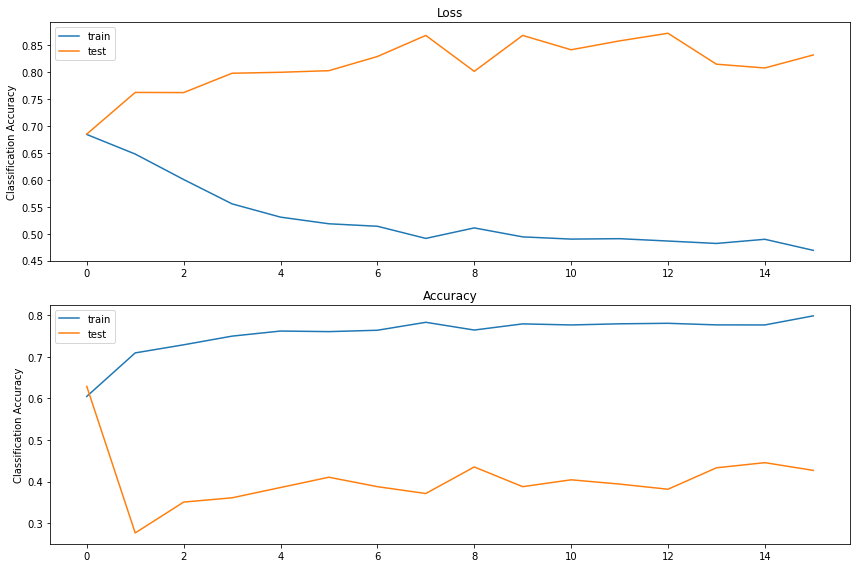

Min of Training Loss: 0.469187
Max of Training Accuracy: 0.798518
Mean of Training Loss: 0.528409
Mean of Training Accuracy: 0.755903
------------
Max of Testing Accuracy: 0.628866
Min of Testing Loss: 0.684626
Mean of Testing Loss: 0.812046
Mean of Testing Accuracy: 0.404897
------------


In [50]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [51]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_lemma.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.6289
Precision Score:	0.8462
Recall Score:		0.6260
f1_score:		0.5949
Test_loss:		0.6846


# BERT TKNZR + LEMMA

In [52]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_twttknr_lemma.values, pheme_y, ext_bert_twttknr_lemma.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0401), std: tensor(0.3291)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [53]:
epochs = 100

model_bert = BERT_net()
total_steps = len(train_dataloader) * epochs

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_twttknr_lemma.pt"

In [54]:
set_seed()
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6269, Loss: 0.6810
		Validation) Acc: 0.5835 Loss:0.6878
			Saving the best model w/ val loss 0.6878
Epoch 2/99	Train) Acc: 0.7535, Loss: 0.5762
		Validation) Acc: 0.3402 Loss:0.7949
Epoch 4/99	Train) Acc: 0.7730, Loss: 0.5125
		Validation) Acc: 0.3526 Loss:0.8706
Epoch 6/99	Train) Acc: 0.7785, Loss: 0.4952
		Validation) Acc: 0.3588 Loss:0.9049
Epoch 8/99	Train) Acc: 0.7799, Loss: 0.4888
		Validation) Acc: 0.4206 Loss:0.8722
Epoch 10/99	Train) Acc: 0.7859, Loss: 0.4700
		Validation) Acc: 0.4165 Loss:0.8997
Epoch 12/99	Train) Acc: 0.7871, Loss: 0.4655
		Validation) Acc: 0.3814 Loss:0.9568
Epoch 14/99	Train) Acc: 0.7859, Loss: 0.4721
		Validation) Acc: 0.4289 Loss:0.8812
Finishing the Model: Val Loss is not decreasing...
[0.8997172661663331, 0.9463412594549435, 0.9567604094436488, 0.9027616746646842, 0.8812210452925299]


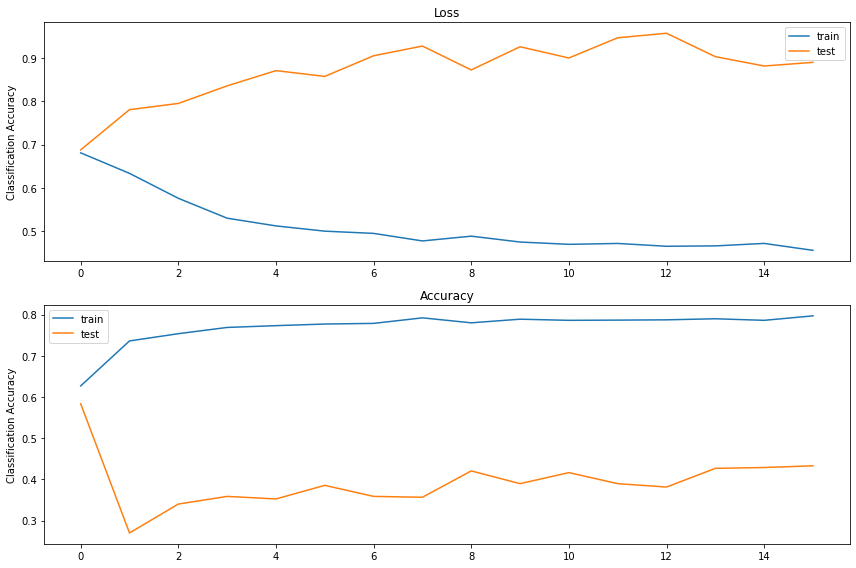

Min of Training Loss: 0.456133
Max of Training Accuracy: 0.796794
Mean of Training Loss: 0.510832
Mean of Training Accuracy: 0.769131
------------
Max of Testing Accuracy: 0.583505
Min of Testing Loss: 0.687827
Mean of Testing Loss: 0.870816
Mean of Testing Accuracy: 0.393299
------------


In [55]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [56]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_twttknr_lemma.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.5835
Precision Score:	0.8584
Recall Score:		0.5420
f1_score:		0.5395
Test_loss:		0.6878


---

## Sparse

In [34]:
#pheme_sparse -> pheme_scaled -> tensor
scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
ext_scaled = pd.DataFrame(scaler.transform(ext_sparse))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled,pheme_y,ext_scaled,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size, test_size = int(tensor_y1.size(0)), int(tensor_y2.size(0))

print("Training: ",tensor_x1.shape,"/", tensor_x2.shape)
print("Testing2: ",tensor_y1.shape,"/", tensor_y2.shape)
print("Train Size",train_size,"/ Test Size",test_size)
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'


Training:  torch.Size([5802, 1, 36]) / torch.Size([485, 1, 36])
Testing2:  torch.Size([5802, 1]) / torch.Size([485, 1])
Train Size 5802 / Test Size 485


In [ ]:
# bert_classifier.load_state_dict(torch.load(PATH))
# testing_process(bert_classifier, X_val, y_val)
predict(model, criterion, val_dataloader, val_size)

In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

NameError: name 'bert_predict' is not defined

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/test_size
    val_acc = val_corrects.double() / val_size

    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    
    print(classification_report(y_test, result))

    return val_acc, val_loss, val_corrects, val_preds_list, val_label_list

# Predicting RHI

In [130]:
rhi = pd.read_csv('./data/_RHI_Bert_final.csv')
rhi_brakcet= pd.read_csv('./data/_RHI_Bert_simple_final_brackets.csv')
rhi_brakcet= pd.read_csv('./data/_RHI_Bert_simple_final_brackets.csv')

In [42]:
def test_data_process(X_test, y_test):
    tensor_x1 = torch.Tensor(X_test.values).unsqueeze(1)
    tensor_y1 = torch.Tensor(y_test.values).unsqueeze(1)
    test_dataset = TensorDataset(tensor_x1,tensor_y1)

    batch_size = 8

    # train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    data = next(iter(test_dataloader))
    print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

    test_size = int(tensor_y1.size(0))

    print("Test Size",test_size)

    # predict_batch
    return test_dataloader, test_size

In [132]:
testloader, test_size = test_data_process(rhi, rhi_y.isRumor)
testloader_brackets, test_size = test_data_process(rhi_brakcet, rhi_y.isRumor)

mean: tensor(0.0402), std: tensor(0.3296)
Test Size 5227
mean: tensor(0.0402), std: tensor(0.3296)
Test Size 5227


In [133]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_simple.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, testloader, test_size)

accuracy_score:		0.3260
Precision Score:	0.9138
Recall Score:		0.2856
f1_score:		0.4080
Test_loss:		0.7189


In [134]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_brackets.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, testloader_brackets, test_size)

accuracy_score:		0.4048
Precision Score:	0.9096
Recall Score:		0.3834
f1_score:		0.5099
Test_loss:		0.7021


In [135]:
# model = BERT_net()
# PATH = './Model/state_dict_bert_model_lemma.pt'
# model.load_state_dict(torch.load(PATH))
# __MLP.predict(model, criterion, testloader_lemma, test_size)

In [136]:
# model = BERT_net()
# PATH = './Model/state_dict_bert_model_twttknr_lemma.pt'
# model.load_state_dict(torch.load(PATH))
# __MLP.predict(model, criterion, testloader_lemma_twtknzr, test_size)